In [1]:
import pandas as pd
import os
import glob

## Get data

For this project we will be using a sequence of the Ramazzottius varieornatus, the YOKOZUNA-1 strain

In [ ]:
!mkdir raw_data

In [ ]:
!wget ftp.ncbi.nlm.nih.gov/genomes/all/GCA/001/949/185/GCA_001949185.1_Rvar_4.0/GCA_001949185.1_Rvar_4.0_genomic.fna.gz -P raw_data
!gunzip raw_data/GCA_001949185.1_Rvar_4.0_genomic.fna.gz

--2022-12-15 10:00:05--  http://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/001/949/185/GCA_001949185.1_Rvar_4.0/GCA_001949185.1_Rvar_4.0_genomic.fna.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.10, 165.112.9.230, 2607:f220:41f:250::230, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.10|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/001/949/185/GCA_001949185.1_Rvar_4.0/GCA_001949185.1_Rvar_4.0_genomic.fna.gz [following]
--2022-12-15 10:00:05--  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/001/949/185/GCA_001949185.1_Rvar_4.0/GCA_001949185.1_Rvar_4.0_genomic.fna.gz
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17621408 (17M) [application/x-gzip]
Saving to: ‘raw_data/GCA_001949185.1_Rvar_4.0_genomic.fna.gz’

GCA_001949185.1_Rva 100%[===================>]  16.

## Structural annotation

AUGUSTUS results were taken from  https://drive.google.com/file/d/1wBxf6cDgu22NbjAOgTe-8b3Zx60hNKY0/view


Script to extract protein sequences (fasta) from the prediction output http://augustus.gobics.de/binaries/scripts/getAnnoFasta.pl

In [ ]:
!perl getAnnoFasta.pl augustus.whole.gff

In [ ]:
!grep -o '>' augustus.whole.aa | wc -l

16435


number of obtained proteins = 16435

## Physical localization 


a list of peptides that were associated with the DNA   
https://disk.yandex.ru/d/xJqQMGX77Xueqg

Now our goal is to figure out which proteins from the R. varieornatus genome these peptides correspond to, and find the relevant ones

### Install conda

In [ ]:
!wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh 
!chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh 
!bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local 

### Install blast

In [ ]:
!conda install -c bioconda blast

Solving environment: \ | / - \ | / - \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - blast


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _openmp_mutex-5.1          |            1_gnu          21 KB
    blast-2.5.0                |       hc0b0e79_3       137.8 MB  bioconda
    boost-1.73.0               |  py37h06a4308_11          25 KB
    bzip2-1.0.8                |       h7b6447c_0          78 KB
    ca-certificates-2022.10.11 |       h06a4308_0         124 KB
    certifi-2022.9.24          |   py37h06a4308_0         154 KB
    conda-22.11.1              |   py37h06a4308_4         921 KB
    flit-core-3.6.0            |     pyhd3eb1b0_0          42 KB
    icu-58.2                   |       he6710b0_3        10.5 MB
    importlib-metadata-4.11.3  |   py37h06a4308_0          40 KB
    importlib_metadata-4.11.3  |  

### Create a database

In [ ]:
!makeblastdb -in augustus.whole.aa -dbtype prot -out blast_database



Building a new DB, current time: 12/15/2022 10:06:29
New DB name:   /content/blast_database
New DB title:  augustus.whole.aa
Sequence type: Protein
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 16435 sequences in 0.764814 seconds.


### Perform search

In [ ]:
!blastp -db blast_database -query peptides.fa -outfmt 6  -out blast_search_result

### Extract proteins of interest from the initial file

In [ ]:
!cut -f2 blast_search_result | sort | uniq > sseqid.txt

In [ ]:
df = pd.read_csv('blast_search_result', sep='\t', comment='#', header=None)
cols = 'qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore'
df.columns = cols.split(' ')
df.head()

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
0,1,g5641.t1,100.000,9,0,0,1,9,25,33,2.0,21.6
1,1,g15153.t1,100.000,9,0,0,1,9,25,33,2.1,21.6
2,2,g5641.t1,100.000,9,0,0,1,9,36,44,1.5,21.9
3,2,g12562.t1,88.889,9,1,0,1,9,36,44,3.3,20.8
4,2,g5616.t1,88.889,9,1,0,1,9,36,44,6.7,20.0


In [ ]:
df.drop_duplicates('sseqid').shape

(34, 12)

In [ ]:
!conda install -c bioconda samtools -y

In [ ]:
!xargs samtools faidx augustus.whole.aa < sseqid.txt > sseqid.fa

[fai_load] build FASTA index.


## Localization prediction

### WoLF PSORT - https://wolfpsort.hgc.jp/

WoLF PSORT predicts the subcellular localization of proteins.

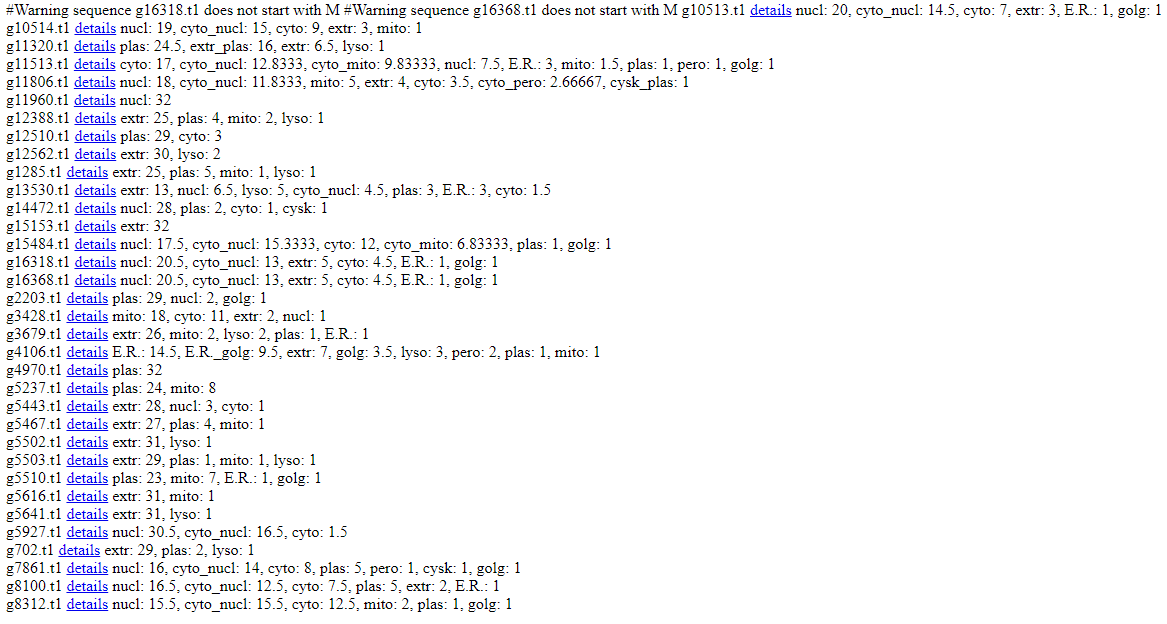

### TargetP 1.1 Server - https://services.healthtech.dtu.dk/service.php?TargetP-2.0

TargetP 1.1 also predicts the subcellular localization of eukaryotic proteins.

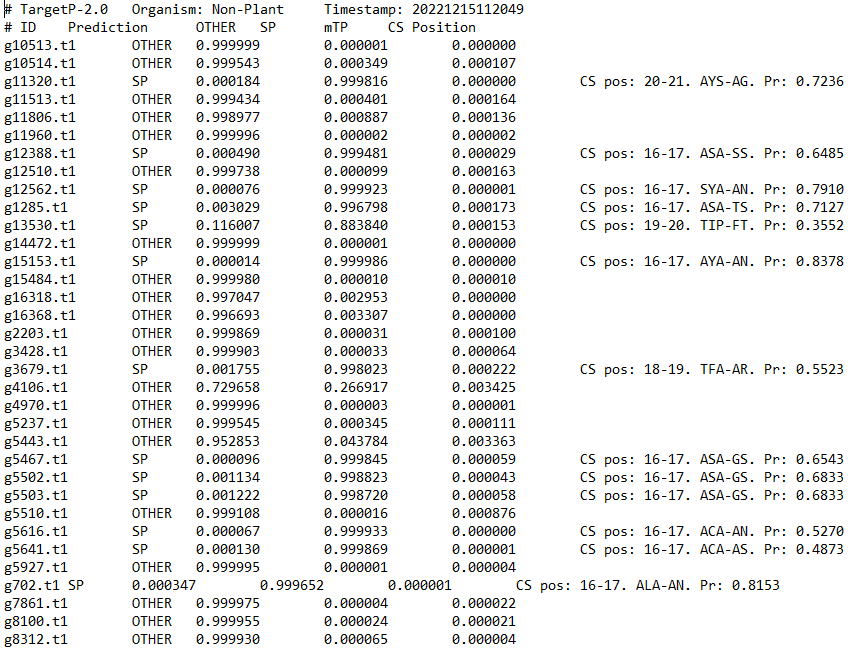

##  BLAST search

BLAST protein sequences against the “UniProtKB/Swiss-Prot” database.

Blast-Alignment-HitTable.csv

In [ ]:
blast_df = pd.read_csv('Blast-Alignment-HitTable.csv', header=None)
cols = 'qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue score bitscore'
blast_df.columns = cols.split(' ')
blast_df.head()

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,score,bitscore
0,g11513.t1,Q32PH0.1,28.607,811,492,19,219,966,143,929,6.610000e-83,296.0,48.21
1,g11513.t1,Q96Q05.2,27.039,932,568,23,218,1060,142,1050,3.570000e-81,291.0,45.60
2,g11513.t1,Q3U0M1.2,26.417,935,568,23,219,1060,143,1050,4.530000e-80,288.0,45.88
3,g11513.t1,Q6PA97.1,29.077,791,484,19,220,948,144,919,2.920000e-77,280.0,47.03
4,g11513.t1,Q9VIL0.2,29.920,498,324,15,392,876,416,901,5.460000e-51,200.0,50.00


In [ ]:
blast_df.shape

(776, 13)

Try to filter by per indent > 40

In [ ]:
res = blast_df[blast_df['pident'] > 40].sort_values('pident', ascending=False).drop_duplicates('qseqid', keep='first')[['qseqid',	'sseqid', 'evalue', 'pident']]
query_coverage = [100, 11, 89, 77, 4, 18, 46, 22, 28, 84, 67]
res['query_coverage'] = query_coverage
res

,qseqid,sseqid,evalue,pident,query_coverage
74,g14472.t1,P0DOW4.1,0.000000e+00,100.000,100
505,g4970.t1,Q04832.1,3.090000e-07,66.667,11
185,g3428.t1,Q9CQ19.3,3.800000e-63,58.442,89
79,g15484.t1,Q505L3.1,0.000000e+00,47.250,77
47,g11960.t1,Q4WZJ6.1,1.000000e-03,46.341,4
611,g5502.t1,P0DPW5.1,2.590000e-06,44.444,18
606,g5467.t1,P0DPW4.1,3.850000e-13,44.118,46
72,g12562.t1,P0DPW5.1,4.780000e-05,42.222,22
627,g702.t1,P0DPW5.1,9.890000e-06,41.935,28
764,g8312.t1,P49754.3,0.000000e+00,41.107,84


## Pfam prediction - HMMER - https://www.ebi.ac.uk/Tools/hmmer/

https://www.ebi.ac.uk/Tools/hmmer/results/ACCBE50E-7C6E-11ED-A57F-BE34642C8881/score

Combine all files to a single df

In [ ]:
csv_files = glob.glob(os.path.join('hmmer', "*.tsv"))
res = []
for f in csv_files:
    df = pd.read_csv(f, sep='\t')
    res.append(df)
hmmer_df = pd.concat(res)
hmmer_df.head()

,Family id,Family Accession,Clan,Env. Start,Env. End,Ali. Start,Ali. End,Model Start,Model End,Bit Score,Ind. E-value,Cond. E-value,Description
0,CBM_14,PF01607.27,CL0155,69,123,73,123,4,53,43.70,2.500000e-11,1.300000e-15,Chitin binding Peritrophin-A domain
0,Glyco_hydro_31,PF01055.29,CL0058,427,844,440,836,39,432,141.44,4.800000e-41,2.400000e-45,Glycosyl hydrolases family 31
0,Clathrin,PF00637.23,CL0020,652,792,654,791,3,142,81.59,5.400000e-23,2.700000e-27,Region in Clathrin and VPS
0,TRAPPC9-Trs120,PF08626.14,-,54,358,66,331,75,307,36.65,9.600000e-10,4.900000e-14,"Transport protein Trs120 or TRAPPC9, TRAPP II ..."
1,TRAPPC9-Trs120,PF08626.14,-,498,949,518,823,552,861,42.77,1.400000e-11,7.000000e-16,"Transport protein Trs120 or TRAPPC9, TRAPP II ..."


## Integrate various pieces of evidence


In [2]:
res = pd.read_csv('results.csv')
res

,num,sequence,Accession_number,evalue,identity,query_cover,WoLF_pediction,TargetP_type,TargetP_likelihood,pfam_prediction
0,1,g5467.t1,P0DPW4.1,3.83e-13,44.118,45.5172413793103,"extr: 27, plas: 4, mito: 1",Signal peptide,0.9998,Chitin binding Peritrophin-A domain
1,2,g5616.t1,P0DPW4.1,2.2e-14,40.964,40.0990099009901,"extr: 31, mito: 1",Signal peptide,0.9999,Chitin binding Peritrophin-A domain
2,3,g15153.t1,P0DPW4.1,1.85e-14,39.759,46.3276836158192,extr: 32,Signal peptide,1.0000,Chitin binding Peritrophin-A domain
3,4,g5503.t1,P0DPW4.1,6.59e-14,39.759,37.6744186046512,"extr: 29, plas: 1, mito: 1, lyso: 1",Signal peptide,0.9987,Chitin binding Peritrophin-A domain
4,5,g5502.t1,P0DPW5.1,2.57e-06,44.444,18.0327868852459,"extr: 31, lyso: 1",Signal peptide,0.9988,Chitin binding Peritrophin-A domain
5,6,g5641.t1,P0DPW4.1,5e-13,39.286,42.7083333333333,"extr: 31, lyso: 1",Signal peptide,0.9999,Chitin binding Peritrophin-A domain
6,7,g12562.t1,P0DPW5.1,4.75e-05,42.222,22,"extr: 30, lyso: 2",Signal peptide,0.9999,Chitin binding Peritrophin-A domain
7,8,g15484.t1,Q505L3.1,0,47.25,77.5193798449613,"nucl: 17.5, cyto_nucl: 15.3333, cyto: 12, cyto...",Other,1.0000,Vps51/Vps67
8,9,g4106.t1,-,-,-,-,"E.R.: 14.5, E.R.golg: 9.5, extr: 7, golg: 3.5,...",Other,0.7297,-
9,10,g5237.t1,-,-,-,-,"plas: 24, mito: 8",Other,0.9995,-
